# Classification with Amazon exployee access data

In this notebook, we explore classification learning with Amazon employee access data from Kaggle.
https://www.kaggle.com/c/amazon-employee-access-challenge/data?select=train.csv
This data has unbalance classes, which makes an interest learning experience. We will progress
- Simple tree
- GridSearch with simple tree
- Gradient boosting with default
- GBT with grid seach for better parameters
- XGB with default
- Deep learning

We make some remarks in-time.

In [1]:
import pandas as pd
import numpy as np
import os

## data exploration

The dataset is downlowded to the local machine, the original data is Kaggle

https://www.kaggle.com/c/amazon-employee-access-challenge/

In [2]:
#(os.getcwd())

In [3]:
data_dir = os.path.join(os.getcwd(), 'data-project\\amazon-ea')

In [4]:
os.listdir(data_dir)

['sampleSubmission.csv', 'test.csv', 'train.csv']

In [5]:
# read the data
train = pd.read_csv(data_dir + '\\train.csv')
test = pd.read_csv(data_dir + '\\test.csv')

In [6]:
train.head(2)

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539


In [7]:
print(test.shape)
test.head(2)

(58921, 10)


,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865


Note the labels are not balanced. The baseline accurary is 94.211%, and thus we will compare the accuracy of an algorithm with thus baseline.

In [8]:
dist = t.ACTION.value_counts()/len(train)
print(dist)
baseline = dist.max()
baseline

1    0.94211
0    0.05789
Name: ACTION, dtype: float64


0.9421099209618847

In [9]:
# No missing value
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

## Start with a simple tree with default parameters

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import KFold

In [11]:
# since all features are categorical data
train = train.astype('category'); 
test = test.astype('category');

The test data has no labels, we use portion of train for testing

In [91]:
# get the features and tagret
features, target = train.iloc[:, 1:], train.iloc[:, :1]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42)

In [78]:
tree= DecisionTreeClassifier(random_state=10)
tree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=10)

In [79]:
# this is worse than the baseline
tree.score(X_test,y_test)

0.9231003967043027

In [80]:
lift =  (tree.score(X_test, y_test ) - baseline)/baseline * 100
print('Now see the best model has %0.2f%%  over the baseline' %lift)

Now see the best model has -2.02%  over the baseline


In [92]:
X_train.shape,  y_train.shape

((22938, 9), (22938, 1))

####  Train with 10 fold CV

In [81]:
tree= DecisionTreeClassifier(random_state=10)
cross_val_score(tree, X, y, cv=10)

array([0.93347574, 0.93317058, 0.93225511, 0.93225511, 0.9295087 ,
       0.92920354, 0.92432103, 0.92859323, 0.93011901, 0.92429792])

In [93]:
from sklearn.metrics import accuracy_score
# KFold Cross Validation approach
kf = KFold(n_splits=10)
  
# Initialize the accuracy of the models to blank list. 
accuracy_model =[]
# Iterate over each train-test split
X = X_train.to_numpy(); y = y_train.to_numpy()
for train_index, test_index in kf.split(X):
    # Split train-test
    X_train_, X_test_ = X[train_index], X[test_index]
    y_train_, y_test_ = y[train_index], y[test_index]
    # Train the model
    tree= DecisionTreeClassifier(random_state=10)
    model = tree.fit(X_train, y_train)
    # Append to accuracy_model the accuracy of the model
    accuracy_model.append(accuracy_score(y_test, model.predict(X_test), normalize = True)*100)

In [94]:
print(accuracy_model)

[92.31003967043027, 92.31003967043027, 92.31003967043027, 92.31003967043027, 92.31003967043027, 92.31003967043027, 92.31003967043027, 92.31003967043027, 92.31003967043027, 92.31003967043027]


This simple model can't beat the baseline

### Grid Seach 

In [103]:
from sklearn.model_selection import GridSearchCV
grid = {
    'criterion': ('gini', 'entropy'),
    'max_depth': list(range(4,12))}

tree= DecisionTreeClassifier(random_state=10)
regessor = GridSearchCV(estimator=tree, param_grid = grid, cv = 10)
regessor.fit(X_train, y_train)
                  

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=10),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11]})

In [104]:
regessor.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=10)

In [105]:
lift =  (regessor.best_estimator_.score(X_test, y_test ) - baseline)/baseline * 100
print('Now see the best model has %0.2f%%  over the baseline' %lift)

Now see the best model has 0.13%  over the baseline


## GBT 

In [106]:
from sklearn.ensemble import GradientBoostingClassifier

GBT with default parameters

In [107]:
# gbt with default
gbm = GradientBoostingClassifier()

In [108]:
gbm.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier()

In [109]:
# this beats the baseline
gbm.score(X_test, y_test)

0.9440545214118604

In [110]:
lift =  (accuracy_score(y_test, gbm.predict(X_test)) - baseline)/baseline * 100
print('Now see the best model has %0.2f%%  over the baseline' %lift)

Now see the best model has 0.21%  over the baseline


In [ ]:
Now we cross examine the misclassified

In [131]:
data = pd.DataFrame({'y_Actual': np.ravel(y_test), 'y_Predicted': gbm.predict(X_test)})
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted   0     1
Actual             
0          11   546
1           4  9270


### Grid search for best parameters

In [149]:
grid = {
#    'criterion': ('friedman_mse','mse'),
    'max_depth': list(range(4,16))
    }

gbm= GradientBoostingClassifier(random_state=10, criterion='mse')
regessor = GridSearchCV(estimator=gbm, param_grid = grid, cv = 8, verbose= 1)
regessor.fit(X_train, np.ravel(y_train))

Fitting 8 folds for each of 12 candidates, totalling 96 fits


GridSearchCV(cv=8,
             estimator=GradientBoostingClassifier(criterion='mse',
                                                  random_state=10),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15]},
             verbose=1)

In [150]:
regessor.best_params_

{'max_depth': 9}

In [151]:
accuracy_score(y_test,regessor.best_estimator_.predict(X_test) )

0.9476146882311057

In [137]:
lift =  (regessor.best_estimator_.score(X_test, y_test ) - baseline)/baseline
print('Now see the best model has %f %%  over the baseline' %(lift*100))

Now see the best model has 0.454739 %  over the baseline


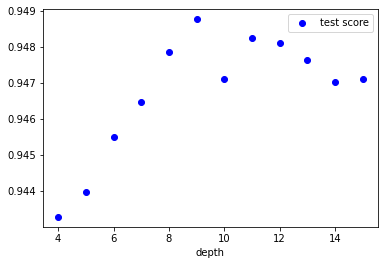

In [154]:
import matplotlib.pyplot as plt

# b+ is for "blue cross"
#plt.plot(grid['max_depth'], regessor.cv_results_['mean_train_score'], 'b+', label='train score')
# "bo" is for "blue dot"
plt.plot(grid['max_depth'], regessor.cv_results_['mean_test_score'], 'bo', label='test score')
plt.xlabel('depth')
plt.legend()

plt.show()

## XGB 

We will experient with two encoders: label encoder and one hot encoder

#### Label encodes feature and class 

In [155]:
from sklearn.preprocessing import LabelEncoder

In [156]:
X, y = train.iloc[:, 1:], train.iloc[:, 0]

In [162]:
train_dic = {}
for col in train.columns: 
    label_encoder = LabelEncoder()
    train_dic[col] = label_encoder.fit_transform(train[col])

In [163]:
X_train = pd.DataFrame(train_dic)
X_labeled = np.copy(X_train)

In [164]:
y_labeled = LabelEncoder().fit_transform(y)

In [165]:
y_labeled

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [166]:
# simplify train, test split
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.3, random_state=42)

In [180]:
from xgboost.sklearn import XGBClassifier
xgbr = XGBClassifier(use_label_encoder=False)

In [181]:
xgbr.fit(pd.DataFrame(X_train), y_train)

[12:52:41] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [182]:
accuracy_score(y_test,xgbr.predict(X_test) )

0.9487335978028685

In [185]:
lift =  (xgbr.score(X_test, y_test ) - baseline)/baseline
print('Now see the best model has %f %%  over the baseline' %(lift*100))

Now see the best model has 0.703068 %  over the baseline


In [184]:
xgbr.score(X_train, y_train ), xgbr.score(X_test, y_test )

(0.9487335978028685, 0.9521754294184323)

Note XGB performed better the GBT with default parameters

## Deep learning 

In [186]:
import keras
from keras import models
from keras import layers

In [187]:
X, y = train.iloc[:, 1:], train.iloc[:, 0]

In [188]:
encoded_x = None
for i in range(0, X.shape[1]):
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X.iloc[:,i])
	feature = feature.reshape(X.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
	feature = onehot_encoder.fit_transform(feature)
	if encoded_x is None:
		encoded_x = feature
	else:
		encoded_x = np.concatenate((encoded_x, feature), axis=1)

In [189]:
from keras.utils.np_utils import to_categorical
y_labeled = y

In [190]:
input_shape = (X_train.shape[1])

In [191]:
input_shape

15626

In [192]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics =metrics)

In [193]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1000128   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,003,297
Trainable params: 1,003,297
Non-trainable params: 0
______________________________________________

In [194]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_x, y_labeled, test_size=0.3, random_state=42)

In [195]:
partial_X_train, X_val, partial_y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

In [196]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=8,
                    validation_data=(X_val, y_val))

Epoch 1/20
2007/2007 [==============================] - 16s 8ms/step - loss: 0.2156 - fn: 0.0000e+00 - fp: 961.0000 - tn: 0.0000e+00 - tp: 15095.0000 - precision: 0.9401 - recall: 1.0000 - val_loss: 0.1726 - val_fn: 0.0000e+00 - val_fp: 379.0000 - val_tn: 0.0000e+00 - val_tp: 6503.0000 - val_precision: 0.9449 - val_recall: 1.0000
Epoch 2/20
2007/2007 [==============================] - 13s 7ms/step - loss: 0.1388 - fn: 118.0000 - fp: 726.0000 - tn: 235.0000 - tp: 14977.0000 - precision: 0.9538 - recall: 0.9922 - val_loss: 0.1731 - val_fn: 94.0000 - val_fp: 277.0000 - val_tn: 102.0000 - val_tp: 6409.0000 - val_precision: 0.9586 - val_recall: 0.9855
Epoch 3/20
2007/2007 [==============================] - 12s 6ms/step - loss: 0.0948 - fn: 203.0000 - fp: 396.0000 - tn: 565.0000 - tp: 14892.0000 - precision: 0.9741 - recall: 0.9866 - val_loss: 0.2060 - val_fn: 192.0000 - val_fp: 256.0000 - val_tn: 123.0000 - val_tp: 6311.0000 - val_precision: 0.9610 - val_recall: 0.9705
Epoch 4/20
2007/2007 

In [272]:
history.history.keys()

dict_keys(['loss', 'fn', 'fp', 'tn', 'tp', 'precision', 'recall', 'val_loss', 'val_fn', 'val_fp', 'val_tn', 'val_tp', 'val_precision', 'val_recall'])

In [197]:
y_pred = model.predict(X_test) 

In [204]:
y_pred = [1 if y_pred[i,0] > 0 else 0  for i in range(y_pred.shape[0])]

In [210]:
print('Test score: %0.3f%%' %accuracy_score(y_test,y_pred))

lift =  (accuracy_score(y_test,y_pred) - baseline)/baseline
print('This model has  a lift: %0.3f%%  over the baseline' %(lift*100))

Test score: 0.943%
This model has  a lift: 0.131%  over the baseline


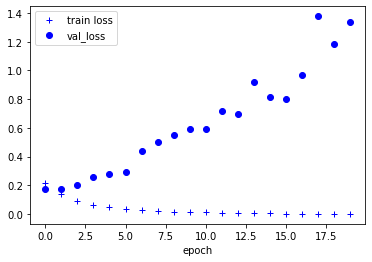

In [274]:
import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(history.history['loss'], 'b+', label='train loss')
# "bo" is for "blue dot"
plt.plot( history.history['val_loss'], 'bo', label='val_loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

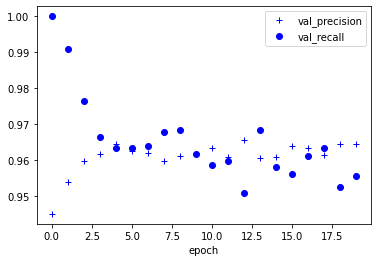

In [275]:
# b+ is for "blue cross"
plt.plot(history.history['val_precision'], 'b+', label='val_precision')
# "bo" is for "blue dot"
plt.plot( history.history['val_recall'], 'bo', label='val_recall')
plt.xlabel('epoch')
plt.legend()

plt.show()

We use several metrics here and can evaluate the model better. From the loss function (train, validation), there is overfitting. 